## 1. 데이터셋 로드 & 전처리

In [4]:
from pandas import DataFrame
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('./usage_data.csv')
display(df.tail(3))

,datetime,temperature,humidity,usage
27661,2019-10-19 03:15:00,8.8,88.4,32.626
27662,2019-10-19 03:30:00,9.2,91.6,38.937
27663,2019-10-19 03:45:00,9.1,90.8,45.018


### 시각화를 통한 데이터 검수

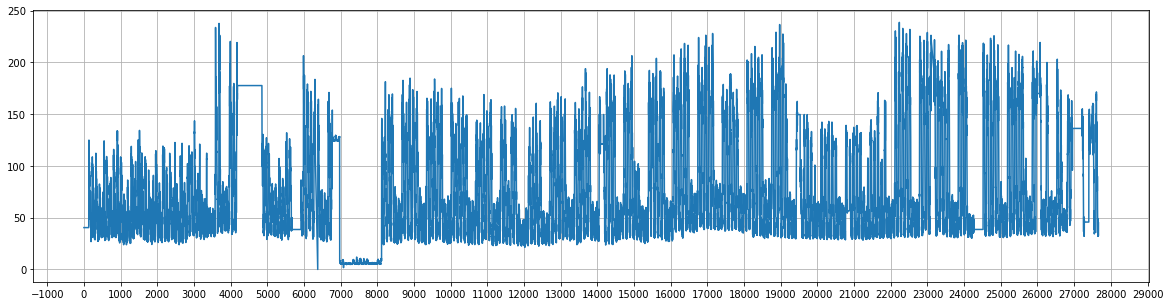

In [48]:
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
plt.grid(True)
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(df.iloc[:,-1])

### 이상 구간 파악
* 같은 값이 반복되는 구간
* 너무 낮은 값을 갖는 구간

#### - 연속적으로 같은 값이 들어오는 구간 제외

In [112]:
df_cp = df.copy()
dff = df.copy()
drop_list = []

i = 0
while i< len(df_cp)-96:
    try:
        max_val = max(df_cp.usage[i:i+96])
        min_val = min(df_cp.usage[i:i+96])
        if max_val==min_val:
            print(f'* drop index : {i}~{i+95}')
            drop_list += [i for i in range(i, i+96)]
            i += 96
        else:
            i+=1
    except:
        print(f'error row:{i}')
        i += 1

* drop index : 0~95
* drop index : 4187~4282
* drop index : 4283~4378
* drop index : 4379~4474
* drop index : 4475~4570
* drop index : 4571~4666
* drop index : 4667~4762
* drop index : 5669~5764
* drop index : 5765~5860
* drop index : 24263~24358
* drop index : 24359~24454
* drop index : 26955~27050
* drop index : 27051~27146
* drop index : 27278~27373


#### - 값이 너무 낮은 구간(< 20) 제외

In [113]:
drop_list =  dl + list(df.loc[df.usage<20].index)

normal_list = [i for i in range(len(usage)) if i not in drop_list]


#### - 전체 데이터 중 제거해야 할 이상구간 표시

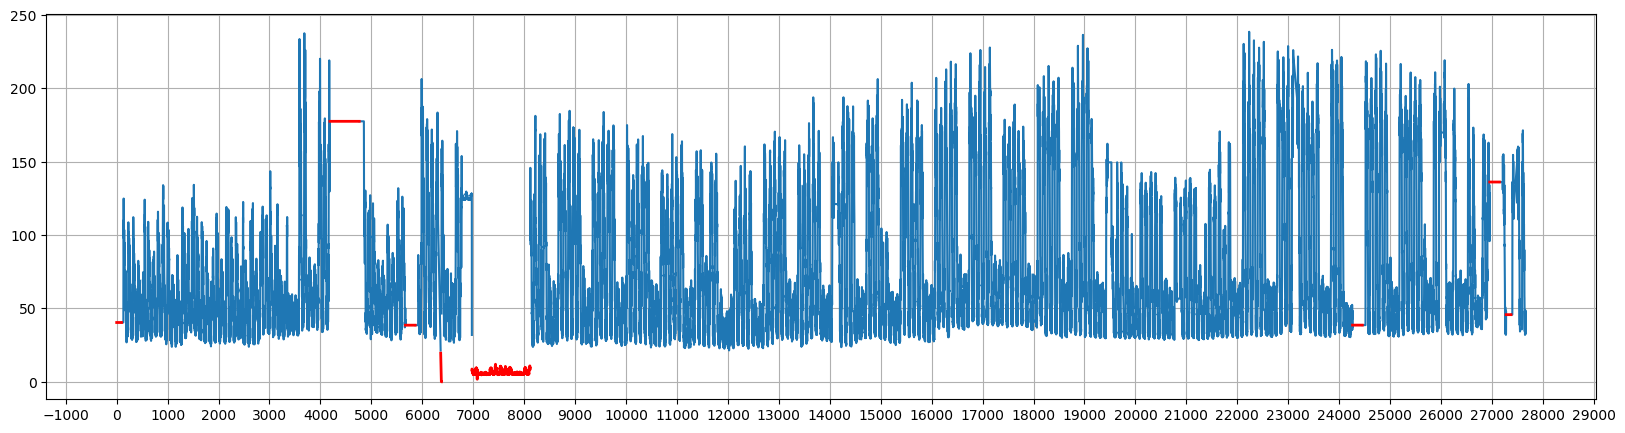

In [128]:
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
plt.grid(True)
plt.rcParams["figure.figsize"] = (20,5)

usage = df.iloc[:,-1]
abnm = usage.copy()
nm = usage.copy()

nm.loc[drop_list] = np.nan
abnm.iloc[normal_list] = np.nan

plt.plot(nm)
plt.plot(abnm, color='red', linewidth=2)

plt.show()



#### - 이상구간이 모두 제거되었는지 확인

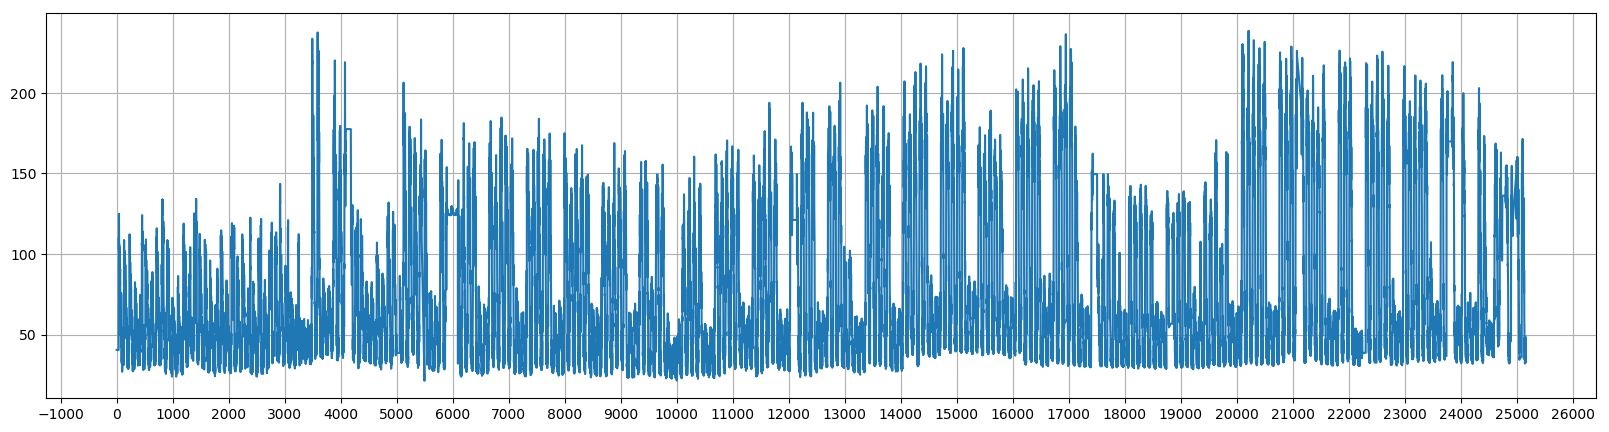

In [135]:
nm = nm.dropna()
nm = nm.reset_index(drop=True)

ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
plt.grid(True)
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(nm)

In [137]:
print(f'{len(drop_list)} 개의 비정상 데이터 제거')

3658 개의 비정상 데이터 제거


In [7]:
from pandas import DataFrame
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import model_from_json
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# scaler 
#########################################################################
def minmax_scaler(X, minmax_range):
    scaled = (X - minmax_range[0]) / (minmax_range[1] - minmax_range[0])
    return scaled
#########################################################################
def create_dataset(data, data2,look_back=192):
    dataX, dataY = [], []
    for i in range(len(data)-2*look_back):
        dataX.append(data[i:(i+look_back)])
        dataY.append(data2[i+2*(look_back)])
    return np.array(dataX), np.array(dataY)
#########################################################################

df = pd.read_csv('/Users/xiilab/Downloads/ztec_1022_v05.csv')
df = df.interpolate(method='linear', limit_direction='both', axis=0)
df = df[df['datetime']>'2019-10-15']

range_dict = {'3':[0,70], '5':[0,1], '7':[0,5], '9':[0,10],'11':[0,15],'13':[0,50],'15':[0,5]}
bd = '3'

pw = np.array(df[bd])
pw = pw.reshape(pw.shape[0],1)
temp = np.array(df['temperature'])
temp = temp.reshape(temp.shape[0],1)
humd = np.array(df['humidity'])
humd = humd.reshape(humd.shape[0],1)
# wday = np.array(df['weekday'])
# wday = wday.reshape(wday.shape[0],1)

pw = minmax_scaler(pw, range_dict[bd])
temp = minmax_scaler(temp, [-40,40])
humd = minmax_scaler(humd, [0,100])
# wday = minmax_scaler(wday, [0,6])

total = np.hstack([pw,temp,humd])
X_train, y_train = create_dataset(total,pw)

print(X_train.shape)
print(y_train.shape)

model = Sequential()
model.add(LSTM(32,input_shape=(X_train.shape[1],3),return_sequences=True))
model.add(LSTM(32,input_shape=(X_train.shape[1],3)))
# model.add(TimeDistributed(Dense(1)))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=672, verbose=2, shuffle=False)

from keras.models import model_from_json

model_json = model.to_json()
jsonname = 'model.json'
h5name = 'model.h5'
with open(jsonname,"w") as json_file:
    json_file.write(model_json)

model.save_weights(h5name)
print("Saved model to disk")
print('finished!')    
    
    


(16, 192, 3)
(16, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 3s - loss: 0.7702
Epoch 2/100
 - 0s - loss: 0.6578
Epoch 3/100
 - 0s - loss: 0.5661
Epoch 4/100
 - 0s - loss: 0.4641
Epoch 5/100
 - 0s - loss: 0.3659
Epoch 6/100
 - 0s - loss: 0.2707
Epoch 7/100
 - 0s - loss: 0.1771
Epoch 8/100
 - 0s - loss: 0.0841
Epoch 9/100


KeyboardInterrupt: 

In [ ]:
from pandas import DataFrame
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import model_from_json
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# scaler 
#########################################################################
def minmax_scaler(X, minmax_range):
    scaled = (X - minmax_range[0]) / (minmax_range[1] - minmax_range[0])
    return scaled
#########################################################################
def create_dataset(data, data2,look_back=192):
    dataX, dataY = [], []
    for i in range(len(data)-2*look_back):
        dataX.append(data[i:(i+look_back)])
        dataY.append(data2[i+2*(look_back)])
    return np.array(dataX), np.array(dataY)
#########################################################################

df = pd.read_csv('/Users/xiilab/Downloads/ztec_1023_v05.csv')
df = df.interpolate(method='linear', limit_direction='both', axis=0)
# df = df[df['datetime']<'2019-10-15']

building = ['3','5','7','9','11','13','15']
range_dict = {'3':[0,70], '5':[0,1], '7':[0,5], '9':[0,10],'11':[0,15],'13':[0,50],'15':[0,5]}
for bd in building:
    
    pw = np.array(df[bd])
    pw = pw.reshape(pw.shape[0],1)
    print(min(pw))
    print(max(pw))
    print('-'*50)
#     temp = np.array(df['temperature'])
#     temp = temp.reshape(temp.shape[0],1)
#     humd = np.array(df['humidity'])
#     humd = humd.reshape(humd.shape[0],1)
#     wday = np.array(df['weekday'])
#     wday = wday.reshape(wday.shape[0],1)

#     pw = minmax_scaler(pw, range_dict[bd])
#     temp = minmax_scaler(temp, [-40,40])
#     humd = minmax_scaler(humd, [0,100])
#     wday = minmax_scaler(wday, [0,6])
    
#     total = np.hstack([pw,temp,humd,wday])
#     X_train, y_train = create_dataset(total,pw)
    
#     print(X_train.shape)
#     print(y_train.shape)

#     model = Sequential()
#     model.add(LSTM(32,input_shape=(X_train.shape[1],4),return_sequences=True))
#     model.add(LSTM(32,input_shape=(X_train.shape[1],4)))
#     # model.add(TimeDistributed(Dense(1)))
#     model.add(Dense(1))

#     model.compile(loss='mae', optimizer='adam')
#     model.fit(X_train, y_train, epochs=100, batch_size=672, verbose=2, shuffle=False)

#     from keras.models import model_from_json

#     model_json = model.to_json()
#     jsonname = 'jc_model(kW)_' + bd + '.json'
#     h5name = 'jc_model(kW)_' + bd +'.h5'
#     with open(jsonname,"w") as json_file:
#         json_file.write(model_json)

#     model.save_weights(h5name)
#     print("Saved model to disk")
# print('finished!!!')    
    
    


## 전력 소비 예측 테스트

### kWh

975
3 start


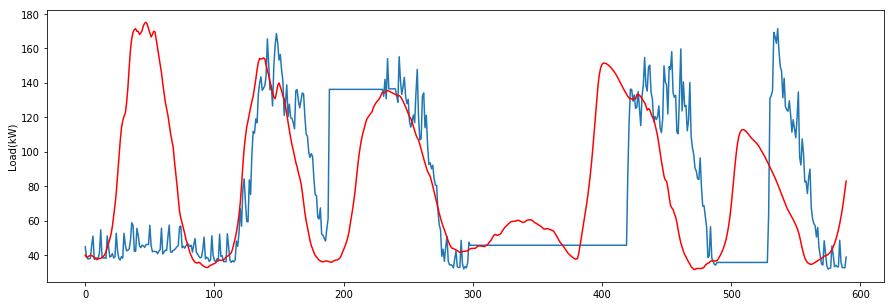

5 start


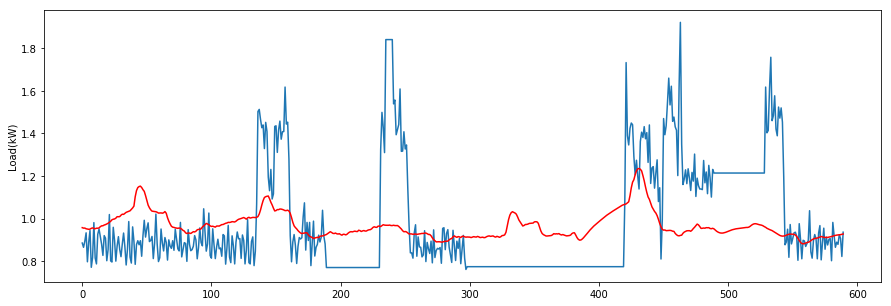

7 start


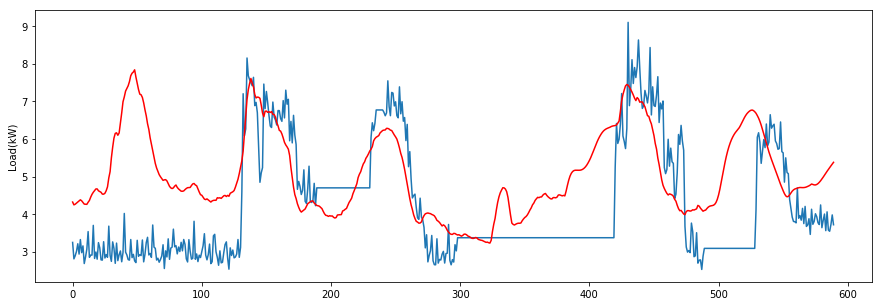

9 start


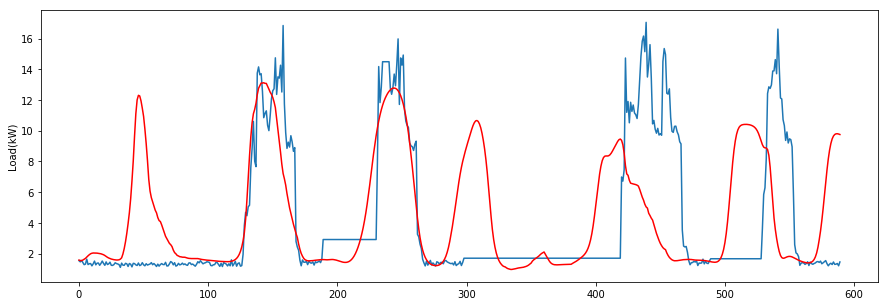

11 start


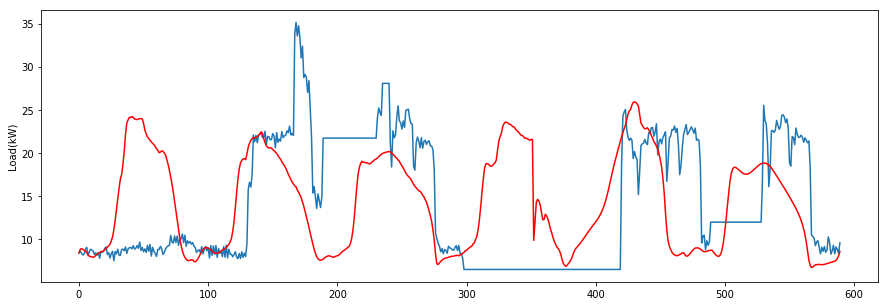

13 start


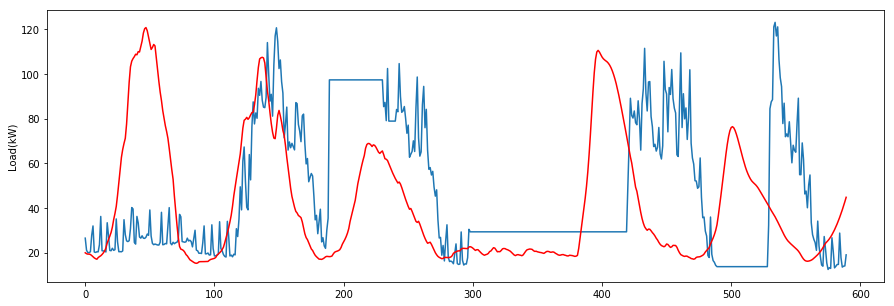

15 start


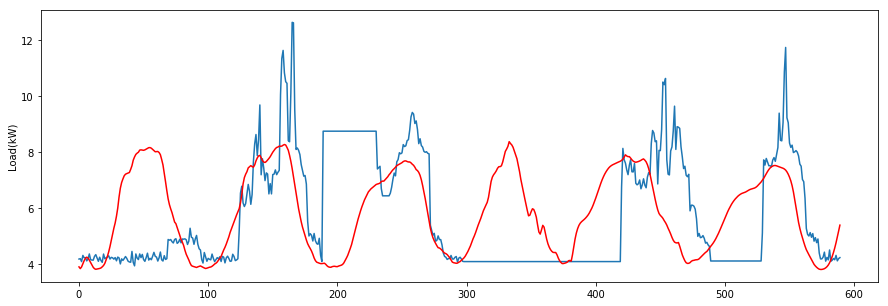

In [73]:
from pandas import DataFrame
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import model_from_json
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

dir = '/Users/xiilab/Documents/파이썬/22222/'
# scaler 
#########################################################################
def minmax_scaler(X, minmax_range):
    scaled = (X - minmax_range[0]) / (minmax_range[1] - minmax_range[0])
    return scaled
#########################################################################
def inverse_scaler(X,minmax_range):
    inv = X * (minmax_range[1]-minmax_range[0]) + minmax_range[0]
    return inv
#########################################################################
def create_dataset(data, data2,look_back=192):
    dataX, dataY = [], []
    for i in range(len(data)-2*look_back):
        dataX.append(data[i:(i+look_back)])
        dataY.append(data2[i+2*(look_back)])
    return np.array(dataX), np.array(dataY)
#########################################################################

df = pd.read_csv('/Users/xiilab/Downloads/ztec_1023_v05.csv')
df = df.interpolate(method='linear', limit_direction='both', axis=0)
df = df[df['datetime']>='2019-10-05']
print(len(df))
building = ['3','5','7','9','11','13','15']
# range_dict = {'3':[0,70], '5':[0,1], '7':[0,5], '9':[0,10],'11':[0,15],'13':[0,50],'15':[0,5]}
range_dict = {'3':[10,250], '5':[0,5], '7':[0,15], '9':[0,30],'11':[0,50],'13':[5,180],'15':[0,20]}
for bd in building:
    
    pw = np.array(df[bd])
    pw = pw.reshape(pw.shape[0],1)

    temp = np.array(df['temperature'])
    temp = temp.reshape(temp.shape[0],1)
    humd = np.array(df['humidity'])
    humd = humd.reshape(humd.shape[0],1)
    wday = np.array(df['weekday'])
    wday = wday.reshape(wday.shape[0],1)

    pw = minmax_scaler(pw, range_dict[bd])
    temp = minmax_scaler(temp, [-40,40])
    humd = minmax_scaler(humd, [0,100])
    wday = minmax_scaler(wday, [0,6])
    
    Test = np.hstack([pw,temp,humd,wday])
    
    print(bd + ' start')
    json_file = open(dir+'jc_model(kW)_'+bd+'.json',"r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights(dir+'jc_model(kW)_'+bd+'.h5')
    model.compile(loss='mse', optimizer='adam')

    predictions = []
    y_test = []
    
    i = 0; cnt = 0
    while (i < len(Test)-385):
        
            # print(cnt)
        X_test, test_y = create_dataset(Test[i:i+385],pw[i:i+385],192)
        pred = model.predict(X_test)
#         pred = pred*(power_max - power_min) + power_min
#         test_y = test_y*(power_max - power_min) + power_min
        predictions.append(pred)
#         predictions = np.append(predictions, pred)
#         y_test = np.append(y_test,test_y)
        y_test.append(test_y)

        i += 1
        cnt += 1
        ########################################################

#     y_test = y_test.reshape(y_test.shape[0],1)
#     predictions = predictions.reshape(predictions.shape[0],1)
    ##### inverse transform ##############
    y_test = inverse_scaler(np.array(y_test),range_dict[bd])
    predictions = inverse_scaler(np.array(predictions),range_dict[bd])
#     print(predictions)
    y_test = np.vstack(y_test).squeeze()
    predictions = np.vstack(predictions).squeeze()
#     predictions = [max(0,predictions[i]) for i in range(len(predictions))]
#     pred = predictions[0]*(power_max - power_min) + power_min
    
#     mape = 0
#     count = 0
#     for i in range(len(y_test)):
#         if (y_test[i] != 0) & (predictions[i] != 0):
#             if(y_test[i] >= np.abs(y_test[i]-predictions[i])):
#                 mape += np.abs(y_test[i] - predictions[i]) / y_test[i]
#                 count +=1
#             else:
#                 mape += np.abs(y_test[i] - predictions[i]) / predictions[i]
#                 count +=1

#     mape /= count

#     print('Mean Absolute Percentage Error : %.3f' % (mape*100))
#     print("Mean Absolute Error   %.3f" %(mean_absolute_error(y_test, predictions)))
    plt.ylabel('Load(kW)')
    plt.plot(y_test)
    plt.plot(predictions,'r')
    # plt.title(name)
    plt.show()    
#     X_train, y_train = create_dataset(total,pw)